Step 1.1: Load Data

In [1]:
from deepdow.benchmarks import OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset
from deepdow.data import RigidDataLoader
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown, CumulativeReturn
from deepdow.nn import BachelierNet
from deepdow.utils import raw_to_Xy
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from pandas_ta import Imports

import pandas as pd
import torch
import yfinance as yf

# CREDIT TO DeepDow library
# This project utilizes DeepDow framework which provides and end-to-end Machine Learning based Portfloio Allocation. 
# Our primary focus is on feature engineering and tuning hyperparameters to show improvement of portfolio allocation using ML model.


2024-02-19 01:32:58.104114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 01:32:58.104156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 01:32:58.104904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 01:32:58.110026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 01:32:58.771912: W tensorflow/compiler/tf2

In [2]:
# DEFINE EXPERIMENT PARAMETER (incl. Hyperparameters) HERE

tickers = ['GOOG','V','JNJ','T','DIS']
start = '2013-01-01'
end = '2023-12-31'

lookback, gap, horizon = 10, 1, 5

In [3]:

original = yf.download(tickers, start=start, end=end)
print('original', original.shape)

/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaInde

original (2768, 30)


Step 1.2: Add Features

In [4]:
features = {
    'RSI': [],
    # 'MACD_12_26_9': [],
    # 'MACDh_12_26_9': [],
    # 'MACDs_12_26_9': [],
    'BBL_5_2.0': [],
    'BBM_5_2.0': [],
    'BBU_5_2.0': [],
    'BBB_5_2.0': [],
    'BBP_5_2.0': [],
    # 'STOCHk_14_3_3': [],
    # 'STOCHd_14_3_3': [],
}
closes = original['Adj Close']
volumes = original['Volume']

print('closes', closes.shape)
print('volumes', volumes.shape)

for ticker in closes.columns:
    close = pd.DataFrame(closes[ticker])
    close.columns = ['close']
    rsi = close.ta.rsi()
    features['RSI'].append(rsi)

    # macd = close.ta.macd()
    # for c in macd.columns:
    #     features[c].append(macd[c])
    
    bbands = close.ta.bbands()
    for c in bbands.columns:
        features[c].append(bbands[c])
    
    # stoch = close.copy()
    # stoch['high'] = stoch['close'].rolling(lookback).max()
    # stoch['low'] = stoch['close'].rolling(lookback).min()
    # stoch.ta.stoch(append=True)

    # for c in ['STOCHk_14_3_3', 'STOCHd_14_3_3']:
    #     s = stoch[c]
    #     features[c].append(s)

raw_df = original.copy()

for k, v in features.items():
    features[k] = pd.concat(v, axis=1)
    features[k].columns = closes.columns
    for col in closes.columns:
        raw_df[(k, col)] = features[k][col]


closes (2768, 5)
volumes (2768, 5)


Step 2: Reformat Data

In [5]:
df = raw_df.swaplevel(0, 1, 1)
df = df.dropna(axis=0)

assert isinstance(df, pd.DataFrame)
assert isinstance(df.index, pd.DatetimeIndex)
assert isinstance(df.columns, pd.MultiIndex)

n_timesteps = len(df)
n_channels = len(df.columns.levels[1])
n_assets = len(df.columns.levels[0])

print('n_timesteps\t', n_timesteps)
print('n_assets\t', n_assets)
print('n_channels (features)\t', n_channels)
print('features', df.columns.levels[1])

n_timesteps	 2754
n_assets	 5
n_channels (features)	 12
features Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI',
       'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0'],
      dtype='object', name='Price')


Step 3: Prepare X, y

In [6]:
print('- lookback \t', lookback)
print('- gap\t\t', gap)
print('- horizon \t', horizon)
X, timestamps, y, asset_names, indicators = raw_to_Xy(df, lookback=lookback,
                                                      gap=gap, freq="B", horizon=horizon)

print('X', X.shape)
print('y', y.shape)
print('asset_names', asset_names)
print('indicators', indicators)

dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

- lookback 	 10
- gap		 1
- horizon 	 5
X (2837, 12, 10, 5)
y (2837, 12, 5, 5)
asset_names ['DIS', 'GOOG', 'JNJ', 'T', 'V']
indicators ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0']


Step 4: Train Model

In [7]:
train_test_ratio = 0.8
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
train_ix = list(range(split_ix))
test_ix = list(range(split_ix + lookback + horizon, n_samples))

train_dataloader = RigidDataLoader(dataset, indices=train_ix, batch_size=32)
test_dataloader = RigidDataLoader(dataset, indices=test_ix, batch_size=32)

In [8]:
max_weight = 0.5
hidden_size = 32
network = BachelierNet(n_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)
loss = SharpeRatio(returns_channel=0)
benchmarks = {'1overN': OneOverN()}
metrics = {'drawdown': MaximumDrawdown(),
           'cumreturn': CumulativeReturn()
           }


run = Run(network,
          loss,
          train_dataloader,
          val_dataloaders={'test': test_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

history = run.launch(n_epochs=20)

Epoch 19: 100%|██████████| 69/69 [00:20<00:00,  3.29it/s, loss=-0.17037, test_loss=0.01180]


Reference: The evaluation and visualization code was from DeepDow example.

In [9]:
per_epoch_results = history.metrics.groupby(
    ['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        533
                             1        533
                             2        533
                             3        533
                             4        533
                             5        533
                             6        533
                             7        533
                             8        533
                             9        533
                             10       533
                             11       533
                             12       533
                             13       533
                             14       533
                             15       533
                             16       533
                             17       533
                             18       533
                             19       533
Name: value, dtype: int64
dataloader  metric  model    epoch
test        loss    network  0        0.016109
                 

<Axes: xlabel='epoch'>

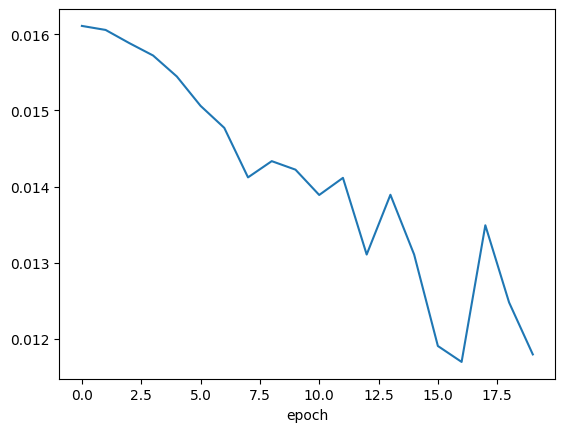

In [10]:
per_epoch_results.mean()['test']['loss']['network'].plot()

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>],
      dtype=object)

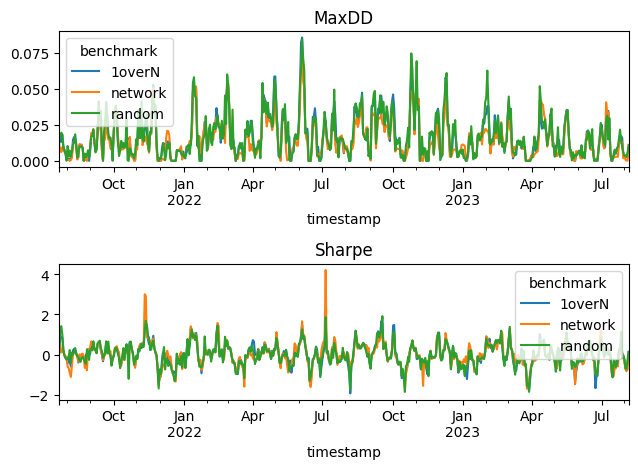

In [11]:

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

array([<Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>,
       <Axes: title={'center': 'CumReturn'}, xlabel='timestamp'>],
      dtype=object)

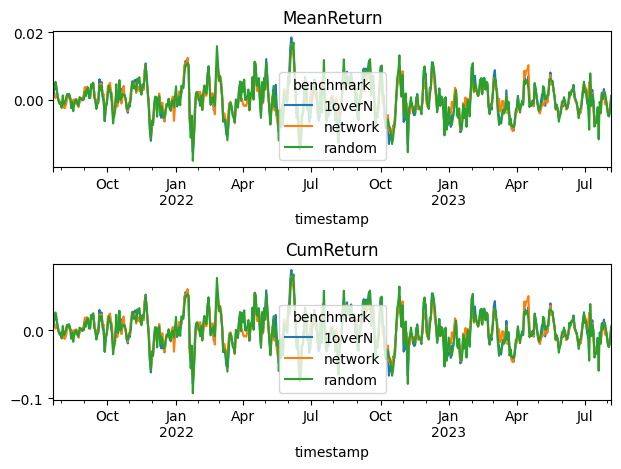

In [12]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}
metrics = {
    'MeanReturn': MeanReturns(),
    'CumReturn': CumulativeReturn()
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

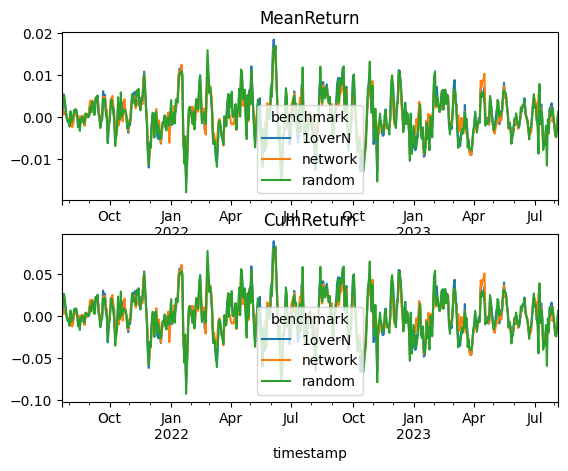

In [18]:
import matplotlib.pyplot as plt

all_metrics = metrics_table["metric"].unique()
n_metrics = len(all_metrics)

_, axs = plt.subplots(n_metrics)

for i, metric_name in enumerate(all_metrics):
    df = pd.pivot_table(
        metrics_table[metrics_table["metric"] == metric_name],
        values="value",
        columns="benchmark",
        index="timestamp",
    ).sort_index()
    df.plot(ax=axs[i])
    axs[i].set_title(metric_name)

plt.show()

<Axes: >

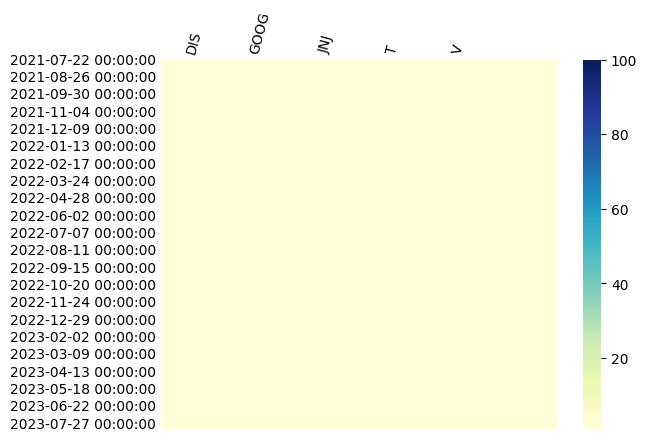

In [19]:

weight_table = generate_weights_table(network, test_dataloader)

plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25,
                    vmin=100)